# Assignment 1

### This notebook consists of 2 parts:
    - Power Law,
    - Random graphs and generative network models.

### You can receive max 20 points for both.

## Complete [this form](https://forms.gle/J9uArMMmG9L6tKGu9) with your name, email and .ipynb until 15.02 23:59 msk

# Power law

## 1. Guess graph by degree distribution (0 points)

Graph is described by the histogram [0, 2, 10] — 0 nodes with degree 0, 2 nodes with degree 1, 10 nodes with degree 2. The goal is to implement a function which can guess graph structure.

<BarContainer object of 3 artists>

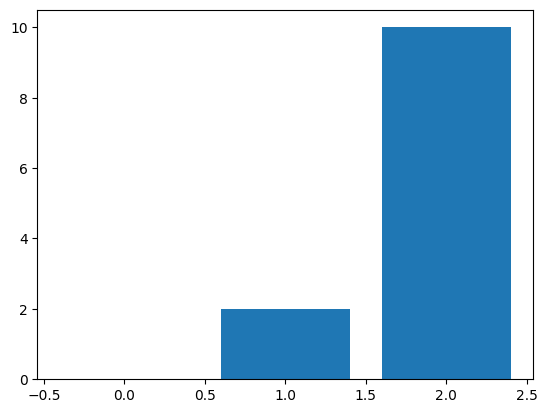

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from typing import List, Tuple
import networkx as nx
import seaborn as sns


dens_a = [0, 2, 10]
plt.bar(range(len(dens_a)), dens_a)

In [97]:
def generate_graph(nodes):
    graph = nx.Graph()
    degrees = np.empty(0)

    #создаем ноды
    graph.add_nodes_from(range(sum(nodes)))

    #массив со свободными связми
    for degree, count in enumerate(nodes):
        degrees = np.append(degrees, np.array([degree]*count))

    while any(degrees!=0):
        non_zero_idx = np.where(degrees != 0)[0]
        u, v = np.random.choice(non_zero_idx, 2)
        if not graph.has_edge(u, v) and u != v:
            graph.add_edge(u, v)
            degrees[u] -=1
            degrees[v] -=1
        # print(len(degrees))

    return graph

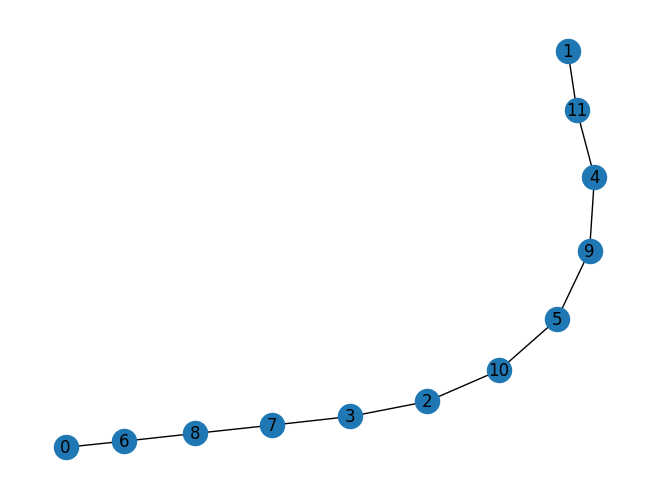

In [98]:
graph= generate_graph(dens_a)
nx.draw(graph, with_labels=True)

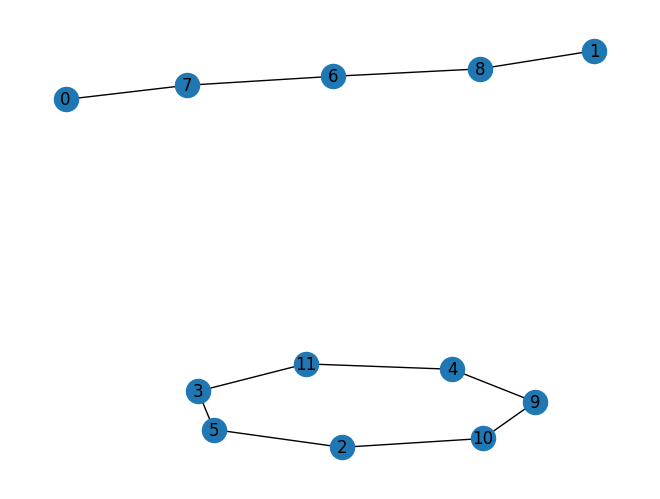

In [91]:
graph= generate_graph(dens_a)
nx.draw(graph, with_labels=True)

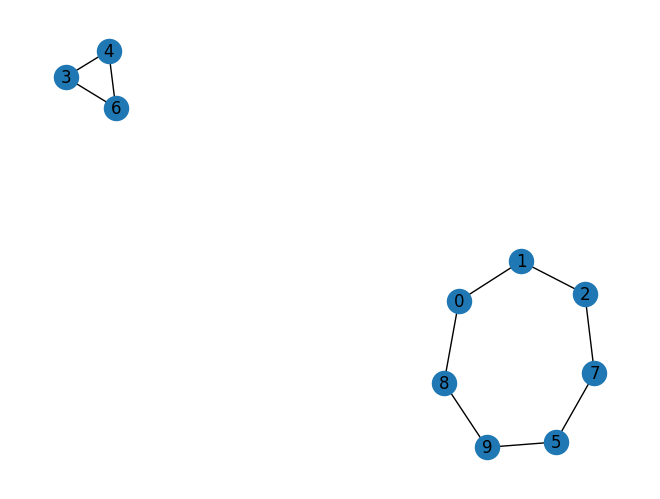

In [99]:
dens_b = [0, 0, 10]
graph= generate_graph(dens_b)
nx.draw(graph, with_labels=True)

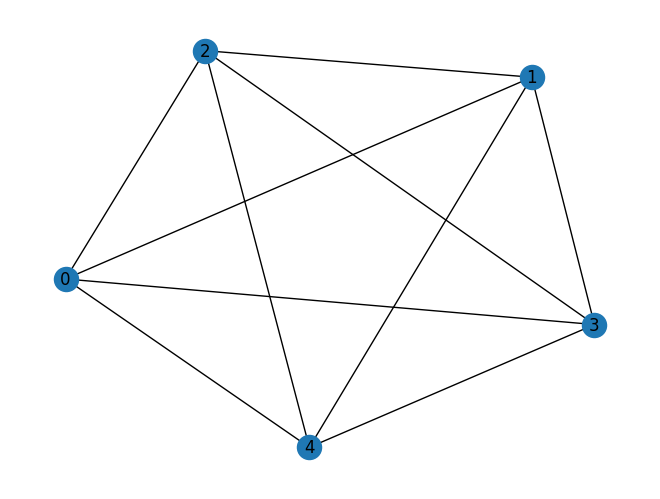

In [100]:
dens_c = [0, 0, 0, 0, 5]
graph= generate_graph(dens_c)
nx.draw(graph, with_labels=True)

## 2. Gygantic connected component (1 point)

Two parameters are expected in the function input: vertices array and edges array. The goal is to implement a function that calculates the gygantic connected component.

In [25]:
def select_gygantic_component(vertices, edges):
    graph = {}
    visited = set()

    # Build the graph
    for vertex in vertices:
        graph[vertex] = set()
    for edge in edges:
        graph[edge[0]].add(edge[1])
        graph[edge[1]].add(edge[0])

    def dfs(node, component):
        visited.add(node)
        component.append(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor, component)

    gigantic_component = []
    for vertex in vertices:
        if vertex not in visited:
            component = []
            dfs(vertex, component)
            if len(component) > len(gigantic_component):
                gigantic_component = component

    return gigantic_component

# Example usage:
vertices = [1, 2, 3, 4, 5]
edges = [(1, 2), (2, 3), (4, 5)]
print(select_gygantic_component(vertices, edges))

[1, 2, 3]


## 3. Power law CDF (1 point)

Let us generate observations from a Power Law RV. The first step is to derive CDF of Powel law:  $𝐹(𝑥)=𝑃(𝑋≤𝑥)$

$$F(x) = 1 - \int_{x}^\infty p(t) dt.$$

The goal is to implement a function with imput parameters x, $\alpha$ and $x_{min}$ that calculates power law CDF. You should take the integral and derive CDF analytically.

In [6]:
def power_law_pdf(x : float, alpha : float = 3.5, x_min : int = 1) -> float:
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)


$$ F(x) = 1 - \int^\infty_x  {C \cdot t^{-\alpha}dt} = 1 -C \cdot \frac{t^{-\alpha + 1} }{-\alpha + 1} \Bigr|_{x}^{\inf} = 1 + C \cdot \frac{ x^{-\alpha + 1}} {-\alpha + 1} = 1 - \frac{x^{1-\alpha}}{x_{min}^{1-\alpha}}, \alpha > 1$$

In [7]:
def power_law_cdf(x : float, alpha : float = 3.5, x_min : int = 1) -> float:
    return 1 - (x/ x_min)**(1-alpha)

## 4. Power law PPF (1 point)

Let $X \sim \text{Power law}$. Next, define a random variable $R$, s.t. $R = F(X)$, so $R$ will be uniformly distributed on interval [0, 1] ([proof](https://en.wikipedia.org/wiki/Probability_integral_transform#Proof)). Good thing here is that we easily can generate uniformly distributed pseudorandom numbers and then transform them into Power Law. Let us find an expression for $x = F^{-1}(r)$, where $r$ is an observation from uniform distrubution on interval [0, 1].

Find an analytical form of $F^{-1}(r)$ and implement a function `power_law_ppf` (percent point function, also known as a quantile) with parameters `r`, `alpha` and `x_min`. Here `r` is a list of observations.

Найдем обратную функцию к $ F(x) = 1 - \frac{x^{1-\alpha}}{x_{min}^{1-\alpha}}$:

$$ F(F^{-1}(u)) = u;  \;\;\;\;\;\; 1 - \frac{(F(u)^{-1})^{1-\alpha}}{x_{min}^{1-\alpha}} = u
\;\;\;\;\;\; $$

$$ F^{-1}(u) = x_{min} \cdot (1-u)^{\frac{1}{1-\alpha}}$$

In [8]:
def power_law_ppf(r : List[float], alpha : float = 3.5, x_min : int = 1) -> List[float]:
    return x_min * ((1-r)**(1/(1-alpha)))

In [9]:
def power_law_generate(n : int, alpha : float = 3.5, x_min : int = 1, random_seed : int = 1) -> List[float]:
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 0.999, n)
    return power_law_ppf(uni_sample, alpha, x_min)

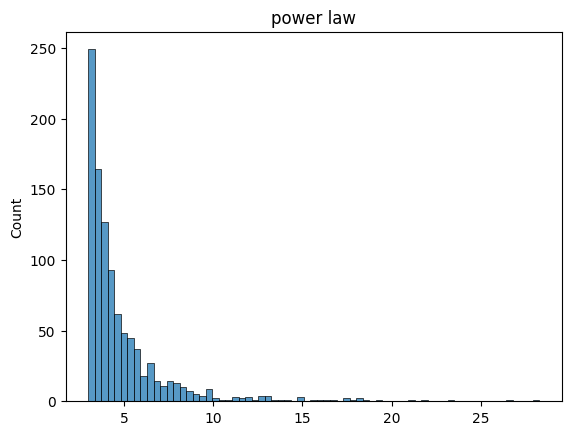

In [355]:
sns.histplot(power_law_generate(1000, x_min = 3))
plt.title('power law')
plt.show()

## 5. Estimation of alpha with linear binning (2 points)

Given observations from the Power Law distribution, try to estimate  𝛼
 . The easiest way is to draw an empirical PDF with linear binning in log-log scale and apply linear regression. By linear binning we mean to keep a bin width is fixed.

The goal is to implement a function alpha_lin_bins that takes a train set, number of linear bins and returns an estimated $\alpha$.

You can use the following hints:

* Take log in both side of  $𝑝(𝑥)=𝐶𝑥^{−𝛼}$
* To calculate an empirical PDF, use np.histogram(x_train, bins=bins, density=True)
* To calculate pseudoinverse matrix, use np.linalg.pinv
* Also you can fit sklearn.linear.LinearRegression

$$ p_i = C \cdot x_i^{-\alpha}; \;\; \log{p_i} = \log{C} - \alpha\log{x_i}$$
Таким образом, можно построить регрессию $\log{p_i}$ на $\log{x_i}$ коэффициент перед $\log{x_i}$ будет равен $-\alpha $.\
np.histogram выдает не прям функцию распределения(высоты бинов не суммируются в 1), но выдает величину пропорнцональную вероятности попасть в бин, коэффициент можно вынести в свободный C, который все равно не нужно оценивать

In [356]:
from sklearn.linear_model import LinearRegression

def alpha_lin_bins(x_train : List[float], bins : int) -> float:
    p, bins_edges = np.histogram(x_train, bins=bins, density=True) #можно и False,тут без разницы
    bins_medians = (bins_edges[1:] + bins_edges[:-1])/2
    log_p, log_x = np.log(p), np.log(bins_medians)
    #в выборке в какой-то бин могли не попасть точки, логарифм нуля получится бесконечным
    mask = np.isinf(log_p)
    log_p, log_x = log_p[~mask], log_x[~mask]
    lr = LinearRegression()
    lr.fit(log_x.reshape(-1, 1), log_p)
    return -lr.coef_[0]

In [357]:
train = power_law_generate(1000, alpha = 4, x_min = 3)
alpha_lin_bins(train, 10)

3.9915069130308067

In [358]:
train = power_law_generate(10000000, alpha = 6, x_min = 3)
alpha_lin_bins(train, 40)

6.017843394635859

## 6. Estimation of alpha with logarithmic binning (2 points)

The goal is to implement a function alpha_log_bins that takes a train set, number of log bins and returns an estimated $\alpha$.

In [359]:
def alpha_log_bins(x_train : List[float], bins : int) -> float:
    p, bins_edges = np.histogram(np.log(x_train), bins=bins, density=True) #можно и False,тут без разницы
    bins_medians = (bins_edges[1:] + bins_edges[:-1])/2
    log_p = np.log(p)
    lr = LinearRegression()
    lr.fit(bins_medians.reshape(-1, 1), log_p)
    return -lr.coef_[0] # +1 почему на 1 меньше??

In [363]:
train = power_law_generate(1000000, alpha = 4)
alpha_log_bins(train, 15), alpha_lin_bins(train, 15)

(3.0072170802516625, 4.0872998243498255)

## 7. Estimation parameters of Power Law by MLE (3 points)

### 7.1. Graph test data

Data for verification.
You need to take the graphs from the social network at the url_1 link to verify your programms. Each of the graphs is defined in the edges file, where each line contains a pair of vertices connected by an edge. It is assumed that there are no vertices with degree 0 in these graphs.

The url_2 link contains a transcript of all the data in the archive at url_1.

Use these dataset to test a function in 7.2.

In [364]:
url_1 = 'https://snap.stanford.edu/data/twitter.tar.gz'
url_2 = 'https://snap.stanford.edu/data/readme-Ego.txt'

In [365]:
import urllib.request
import tarfile
urllib.request.urlretrieve(url_2, "readme.txt")
urllib.request.urlretrieve(url_1, "test.tar.gz")
file = tarfile.open("test.tar.gz")
file.extractall('./test_folder')

In [366]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [52]:
# Example: how to read edges
edges = []
for line in open('./test_folder/twitter/12831.edges', "r"):
    values = line.split()
    if not values:
        continue
    edges.append((np.array([values[0], values[1]], dtype = int)))
edges = np.array(edges)

### 7.2. Estimation parameters of Power Law by MLE

The MLE consists of:
1. Fix $x_\min$ as a minimal node degree (drop node degrees that less than $x_\min$)
2. Calculate $\alpha$ via maximum likelihood estimation using fixed $x_\min$
$$\alpha = 1 + n \left[\sum_i \log \frac{x_i}{x_\min} \right]^{-1}$$
3. Calculate Kolmogorov-Smirnov test
4. Fix $x_\min$ as the next node degree
5. Repeat 2-4 by scanning all possible $x_\min$ and find the best $\alpha$ and $x_\min$ with respect to Kolmogorov-Smirnov test

The goal is to implement a function `ml_power_law_params` that takes a node degree sequence `degree_sequence` and returns a tuple of two values: the best $\alpha$ and $x_\min$.

_Hint: use `scipy.stats.kstest` where a theoretical CDF is a `power_law_cdf` function and `args=(alpha, k_min)`_

Use the data provided in 7.1 to test your function.

In [85]:
from scipy.stats import kstest
def mle_power_law_params(degree_sequence):
    p_value_max = 0
    x_min_res = -1
    alpha_res = -1
    
    for x_min in np.sort(degree_sequence)[:-1]:
        #обрубаем тех, у кого меньше текущего x_min
        cur_examples = degree_sequence[degree_sequence>x_min]
        #оценка макс правдоподобия
        mle_est = 1 + len(cur_examples) * (np.sum(np.log(cur_examples)/x_min))**(-1)
        p_value = kstest(cur_examples, lambda x: power_law_cdf(x, alpha = mle_est, x_min = x_min))[1]
        # ищем максимальный p_value
        if p_value>p_value_max:
            p_value_max = p_value
            x_min_res = x_min
            alpha_res = mle_est
            
            # print('!'*20)
            
    return alpha_res, x_min_res

In [80]:
train = power_law_generate(1000, alpha = 4, x_min = 1)
mle_power_law_params(train)

(4.01167213103947, 1.0042164499919863)

протестируем на других данных

In [67]:
unique, counts = np.unique(edges.flatten(), return_counts=True)

In [72]:
a, x_min = mle_power_law_params(counts)
print(f'alpha = {round(a,2)}, x_min = {x_min}')

alpha = 16.64, x_min = 67


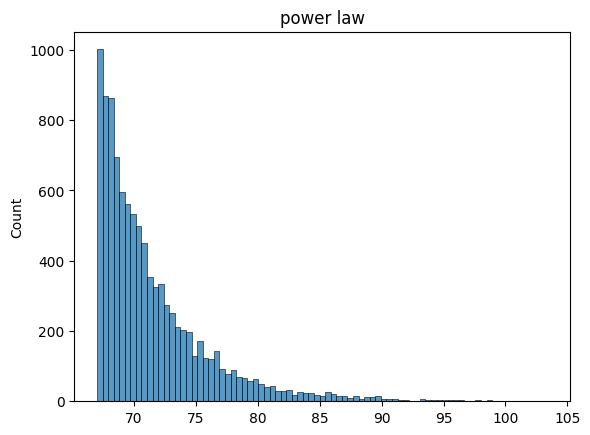

In [82]:
sns.histplot(power_law_generate(10000, 16.64, x_min = 67))
plt.title('power law')
plt.show()

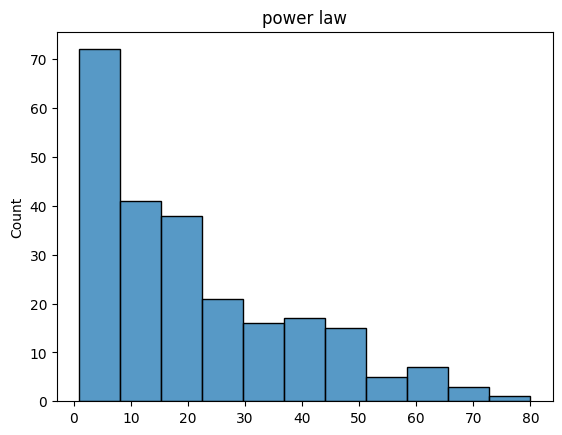

In [83]:
sns.histplot(counts)
plt.title('power law')
plt.show()

похоже оценка получилась не очень хорошая. видно, что x_min явно не 67. видимо по малому количеству точек лучше всего удалось пройти по p_value

# Random graphs and generative network models

## 1. Erdos-Renyi model (0.5 point)

Two parameters are expected in the function input: vertices array and p parameter. The goal is to implement Erdos-Renyi model (random graph) — each pair of  𝑛 nodes are connected with some fixed probability 𝑝.

In [2]:
import numpy as np
from typing import List, Tuple
from itertools import combinations

def erdos_renyi_graph(nodes : np.ndarray, p : float) -> List[np.ndarray]:
    possible_edges = np.array(list(combinations(nodes, 2)))
    mask = np.random.rand(len(possible_edges))<p
    random_edges = possible_edges[mask]
    return random_edges        

### 1.1. Graph visualization and test data

Data for verification.
You need to take the graphs from the social network at the url_1 link to verify your programms. Each of the graphs is defined in the edges file, where each line contains a pair of vertices connected by an edge. It is assumed that there are no vertices with degree 0 in these graphs.

The url_2 link contains a transcript of all the data in the archive at url_1.

Use this code to visualize test graphs from url provided below. This dataset is required for tests of the functions you will implement if the next tasks of this assignment.

In [3]:
url_1 = 'https://snap.stanford.edu/data/facebook.tar.gz'
url_2 = 'https://snap.stanford.edu/data/readme-Ego.txt'

In [4]:
import urllib.request
import tarfile
urllib.request.urlretrieve(url_2, "readme.txt")
urllib.request.urlretrieve(url_1, "test.tar.gz")
file = tarfile.open("test.tar.gz")
file.extractall('./test_folder')

In [6]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [7]:
# Example: how to read edges
edges = []
for line in open('./test_folder/facebook/107.edges', "r"):
    values = line.split()
    if not values:
        continue
    edges.append(totuple(np.array([values[0], values[1]], dtype = int)))

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G1 = nx.Graph()
G1.add_edges_from(edges)

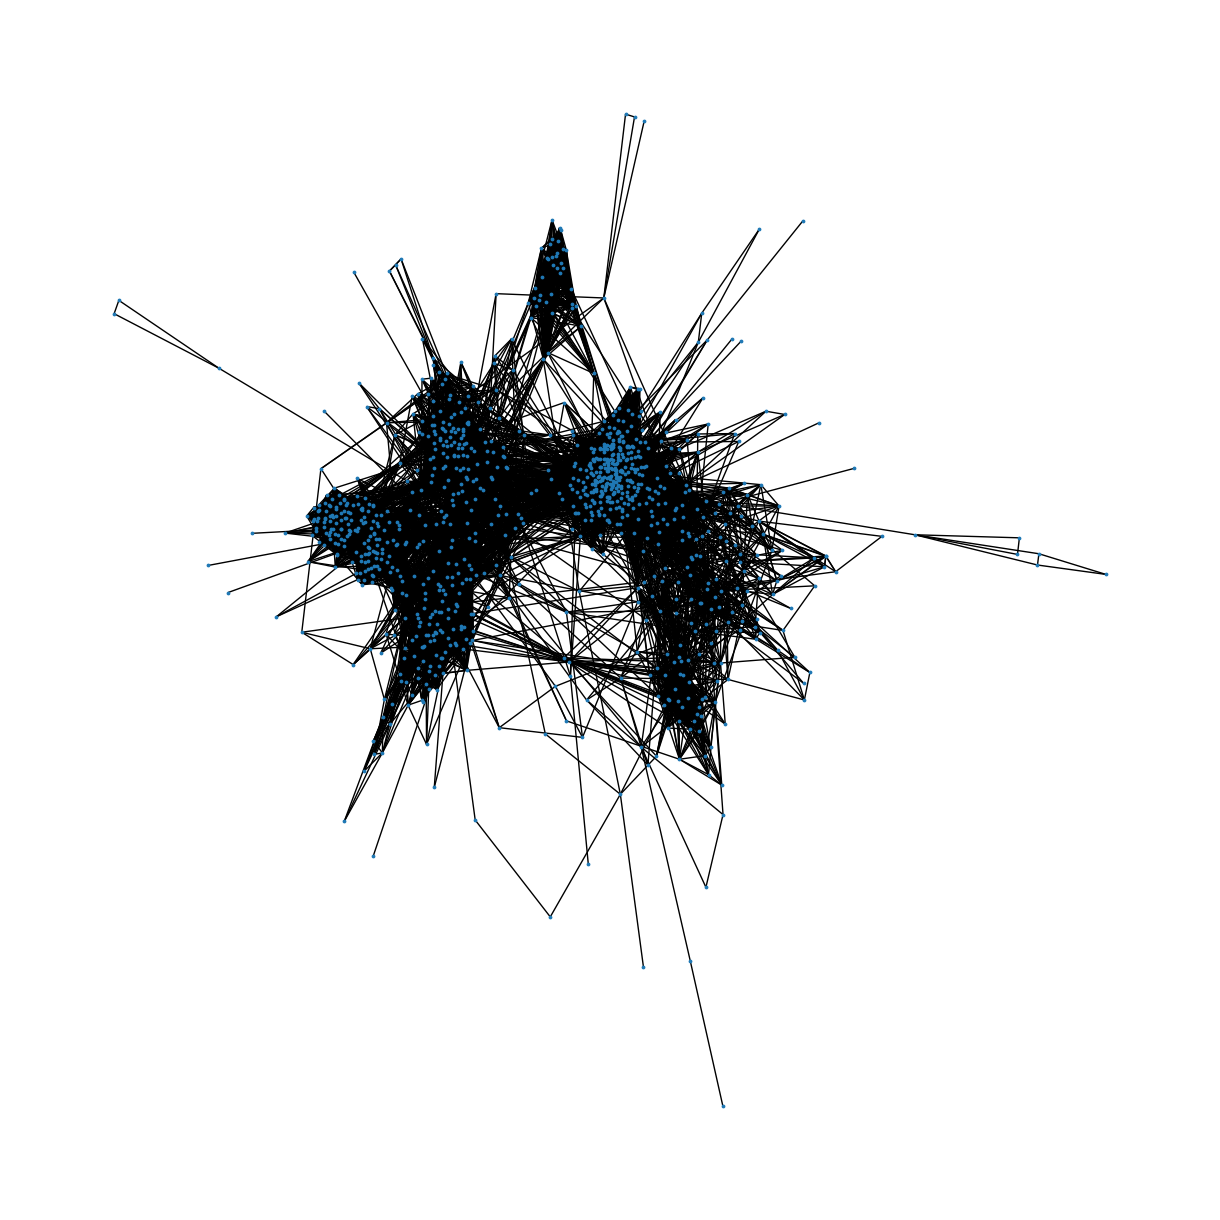

In [13]:
plt.figure(figsize=(12,12))
nx.draw(G1, node_size=3)
plt.show()

## 2. Vertices degrees distribution (0.5 point)

Two parameters are expected in the function input: vertices array and edges array. The goal is to implement a function that calculates the parameters n and p of the binomial distribution of the degrees of vertices of the graph.

Test this function of the graphs provided via the url in task 1.1.

In [14]:
#оценка - доля связей из всех вохможных n*(n-1)/2
def estimate_binomial(nodes : np.ndarray, edges : List[np.ndarray]) -> [int, float]:
    return 2* len(edges)/(len(nodes)*(len(nodes)-1)) 

In [15]:
estimate_binomial(np.array(G1.nodes), np.array(G1.edges))

0.05008603886072939

## 3. Poisson distribution to evaluate a vertices degrees distribution (0.5 point)

Two parameters are expected in the function input: vertices array and edges array. The goal is to implement a function that calculates the parameters 𝜆 of the Poisson distribution of the degrees of vertices of the graph.

Test this function of the graphs provided via the url in task 1.1.

In [22]:
def estimate_poisson(nodes : np.ndarray, edges : List[np.ndarray]) -> int:
    p = estimate_binomial(nodes, edges)
    raise p * len(nodes)

## 4. Graph's component average size (1 points)

Two parameters are expected in the function input: number of graph vertices and probability p for Erdos-Renyi model. The goal is to implement a function that generates random graph for each probability from probabilities array. It is required to evaluate average siz of small graph components for each graph generated. Function returns an array of average sizes.

In [40]:
def largest_connection_component(nodes: int, probabilities: np.ndarray) -> np.ndarray:
    avg_sizes = []
    for p in probabilities:
        sizes = []
        for _ in range(100):
            #генерируем граф
            random_edges = erdos_renyi_graph(np.arange(nodes), p)
            # размер самой большой компоненты
            largest_component_size = len(select_gygantic_component(np.arange(nodes), random_edges))
            sizes.append(largest_component_size)
        avg_size = np.mean(sizes)
        avg_sizes.append(avg_size)
    return np.array(avg_sizes)

In [45]:
nodes = 100
probabilities = np.linspace(0, 0.12, 10) # при больших вероятностях все 100 будут связаны
average_sizes = largest_connection_component(nodes, probabilities)
print(average_sizes)

[  1.    42.03  91.02  98.09  99.52  99.89  99.94  99.99 100.   100.  ]


## 5. Graph's shortest path average length (1 points)

Two parameters are expected in the function input: the first array contains average degrees of graphs, the second one contains amount of graphs vertices. The goal is to generate random graphs with corresponding average degree and amount of vertices. Function is expected to return an array of average lengths of graphs shortest paths.

In [54]:
def average_shortest_path_length(average_degree: np.ndarray, nodes_number: np.ndarray) -> np.ndarray:
    avg_lengths = []
    for degree, nodes in zip(average_degree, nodes_number):
        lengths = []
        for _ in range(10):  
            edges = erdos_renyi_graph(np.arange(nodes), degree/nodes)
            avg_length = nx.average_shortest_path_length(nx.from_edgelist(edges))
            lengths.append(avg_length)
        avg_lengths.append(np.mean(lengths))
    return np.array(avg_lengths)

In [59]:
average_degrees = np.array([10, 15, 50])
nodes_numbers = np.array([50, 100, 150])
average_lengths = average_shortest_path_length(average_degrees, nodes_numbers)
print(average_lengths)

[1.86628571 1.91630303 1.66442953]


## 6. Clustering coefficient (0.5 point)

Two parameters are expected in the function input: vertices array and p parameter for Erdos-Renyi model. The goal is to generate a random graph and calculate all vertices' degrees and clustering coefficients.

In [70]:
def clustering_coefficient(nodes : np.ndarray, p : float) -> [np.ndarray, np.ndarray]:
    graph = nx.from_edgelist(erdos_renyi_graph(nodes,p))
    cluster_coefs = nx.clustering(graph)
    degrees = graph.degree
    return np.fromiter(map(lambda node: degrees[node],nodes),float),np.fromiter(map(lambda node: cluster_coefs[node],nodes),float)

In [71]:
clustering_coefficient(np.arange(15), 0.5)

(array([ 6.,  9.,  6.,  7.,  8.,  9.,  7.,  8.,  9.,  5.,  7.,  8.,  8.,
         5., 10.]),
 array([0.66666667, 0.52777778, 0.46666667, 0.57142857, 0.53571429,
        0.47222222, 0.42857143, 0.5       , 0.44444444, 0.4       ,
        0.52380952, 0.46428571, 0.53571429, 0.7       , 0.51111111]))

## 7. Watts-Strogatz model (2 point)

The goal is to implement a function Watts-Strogatz model (small-world model) — rewire an edge with probability $p$ in a ring lattice with $n$ nodes and $k$ degree.

This function should be splitted into little functions described below.

In [90]:
from tqdm import tqdm
from random import choice
def watts_strogatz_graph(nodes : np.ndarray, k : int, p : float) -> List[np.ndarray]:
    AdjList = ring_lattice(nodes, k)
    for node in tqdm(nodes):
        rewire(AdjList, node, k, p)
    return AdjList

A ring_lattice function generates a regular ring lattice with $n$ nodes $(0, 1, 2, ..., n-1)$ and $k$ node degree. In a case of an odd node degree, it round it to the nearest smaller even number.

In [82]:
def ring_lattice(nodes : np.ndarray, k : int) -> List[np.ndarray]:
    k = k - k % 2
    adjacency_list = {}
    for i, node in enumerate(nodes):
        adjacency_list[node] = []
        for j in range(1,k // 2 + 1):
            next_node = (i + j) % len(nodes)
            adjacency_list[node].append(nodes[next_node])
    return adjacency_list

A function `rewire` takes in input a ring lattice defined by adjacency list `AdjList`. The other input parameters are: a `node`, a model parameter `k` and probability `p`. For every right hand side neighbor $i$, the function rewires an edge (`node`, $i$) into a random edge (`node`, $j$) with probability `p` where $i \neq j \neq $ `node`.

*Hints:*
* *Why do we only rewire right hand side edges? We want to guarantee that only untouched in previous iterations edges will be rewound. Look at the picture — we could not move the red edges in previous iterations.*

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/watts_strogatz_how_to_rewire.png)

* *To speed up the generation, do not filter nodes to random selection. If a selected node produces an existing edge or a loop, just skip it.*

Function should return rewired adjacency list.

In [83]:
def rewire(AdjList : List[np.ndarray], node : int, k : int, p : float) -> None:
    neighbors = AdjList[node]
    candidates = list(AdjList.keys())
    for i, nbr in enumerate(neighbors):
        prob = np.random.rand()
        candidate = choice(candidates)

        if prob < p and candidate != node and candidate != nbr \
        and node not in AdjList[candidate] and candidate not in AdjList[node]:
            AdjList[node][i] = candidate

100%|████████████████████████████████████████| 14/14 [00:00<00:00, 15579.80it/s]


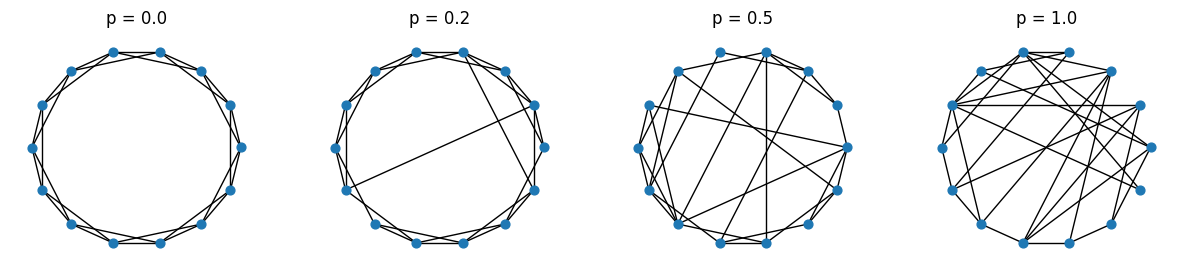

In [94]:
n = 14
k = 4
ps = [0, 0.2, 0.5, 1]
fig = plt.figure(figsize=(15, 3))
for i in range(len(ps)):
    ax = plt.subplot(1, len(ps), i+1)
    G = nx.from_dict_of_lists(watts_strogatz_graph(np.arange(n),k,ps[i]))
    ax.set_title('p = %.1f' % ps[i])
    nx.draw_circular(G, node_size=40)
plt.show()

## 8. Barabasi-Albert model (2 point)

The goal is to implement Barabasi-Albert model (preferential attachment model) -- a growth process where each new node connects to `m` existing nodes. The higher node degree, the higher probability of the connection. The final number of nodes is `n`.

You start from a star graph with `m + 1` nodes. In each step you create `m` edges between a new node and existing nodes. The probability of connection to the node $i$ is
$$p(i) = \frac{k_i}{\sum k}$$

The function requres another function described below.

In [99]:
from tqdm import trange 
def star_graph(m) -> List[np.ndarray]:
    centr_node = m
    return {node : [centr_node] for node in range(m)}

def barabasi_albert_graph(n : int, m : int) -> List[np.ndarray]:
    AdjList = star_graph(m)
    for i in trange(1, n - m):
        attach(m + i, AdjList, m)
    return AdjList

A function `attach` attaches a `node` to a graph `G` through `m` edges. It should not return any variables but just change an adjacency list passed to the input.

*Hint: Create a list with repeated nodes from a list of edges. For example, $[(1, 2), (2, 3), (2, 4)] \to [1, 2, 2, 3, 2, 4]$. Uniformly select nodes one-by-one. Apply `random.choice` instead of `np.random.choice` to speed up the generation.*

In [100]:
def attach(node : int, AdjList : List[np.ndarray], m : int) -> None:
    repeated_nodes = sum([[key,node] for key,nodes in AdjList.items() for node in nodes],[])
    candidates = set()
    AdjList[node] = []
    for _ in range(m):
        candidate = choice(repeated_nodes)
        while candidate in candidates:
            candidate = choice(repeated_nodes)
        candidates.add(candidate)

        AdjList[node].append(candidate)

100%|██████████████████████████████████████████| 93/93 [00:00<00:00, 244.19it/s]


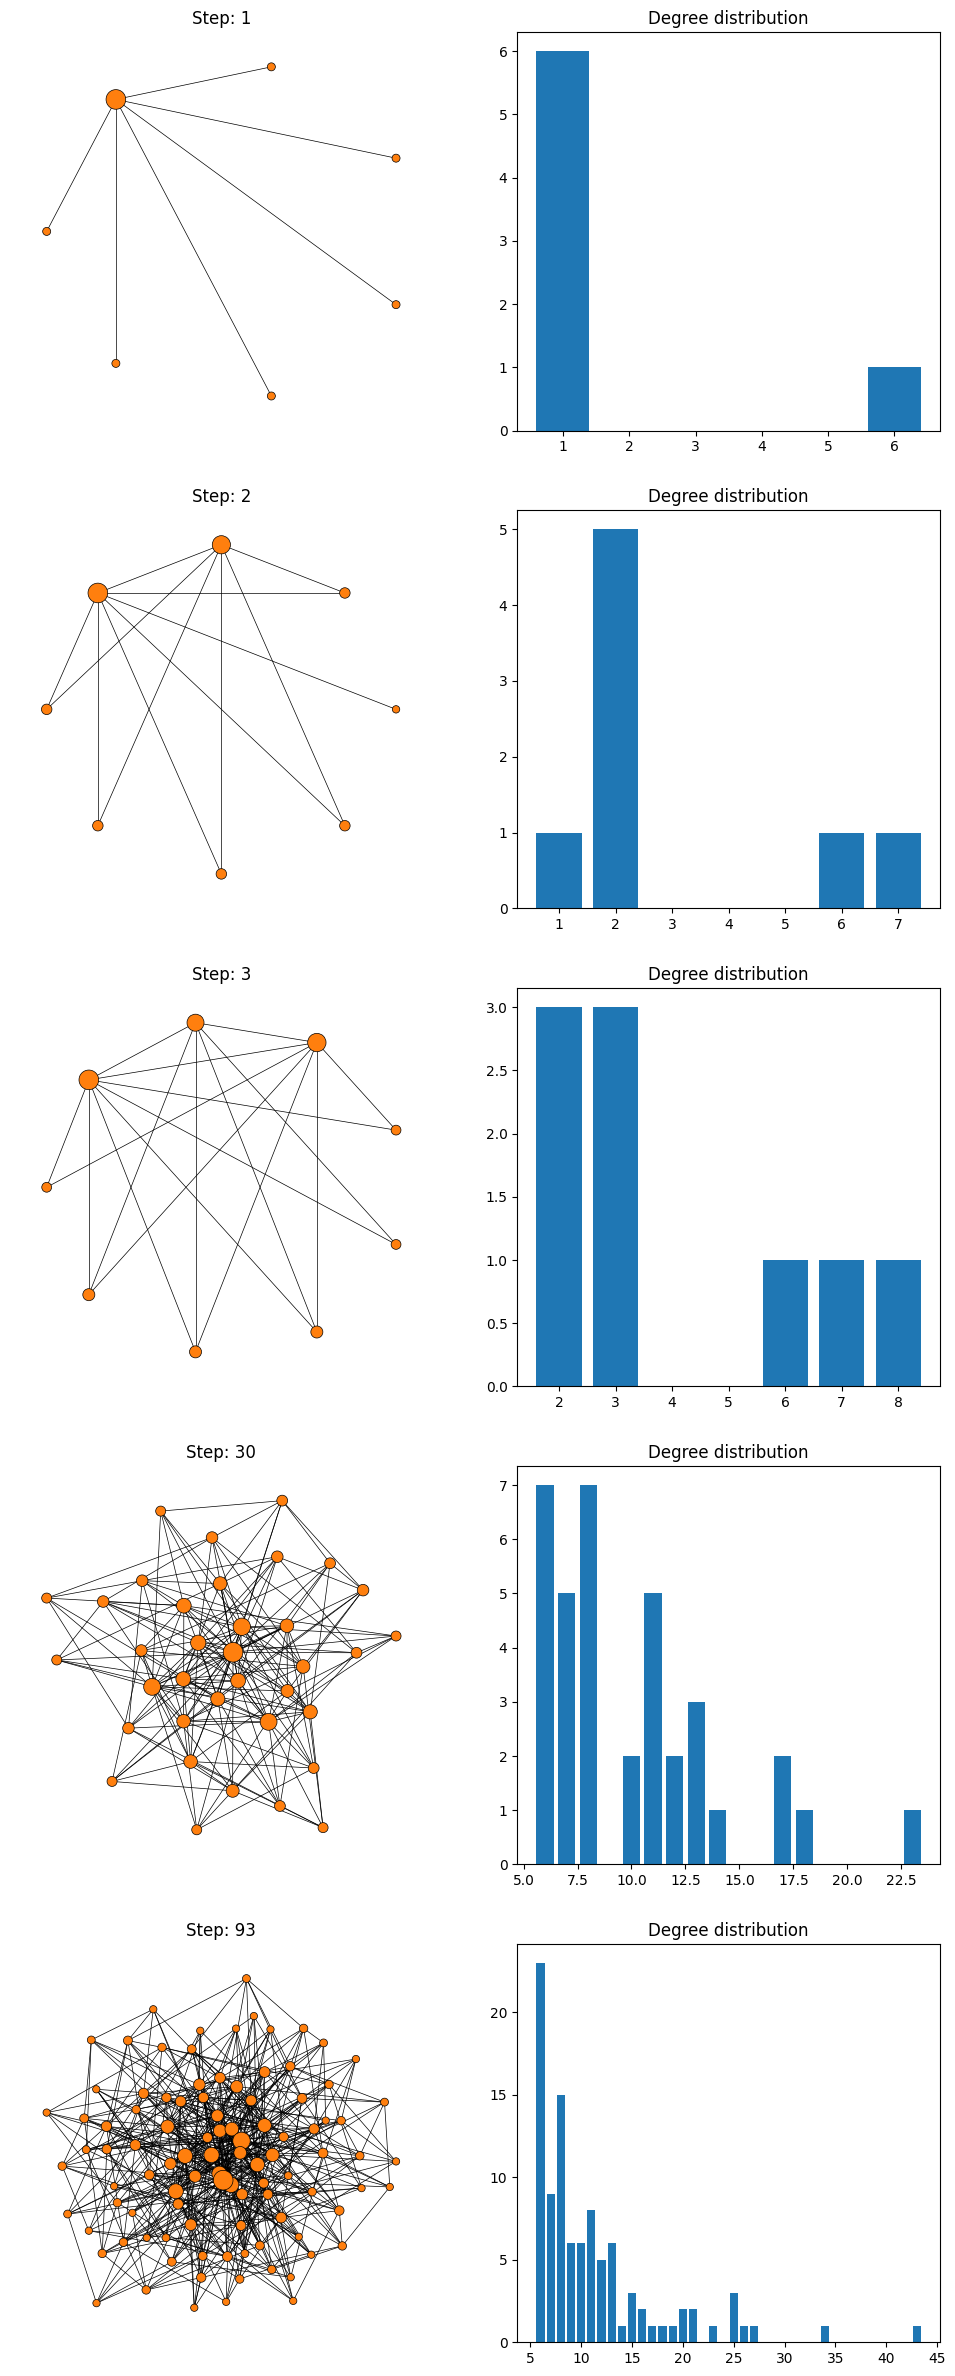

In [101]:
n, m = 100, 6
G = star_graph(m)
plt.figure(figsize=(12, 6 * 5))
j = 1
for i in trange(1, n - m):
    if i in [1, 2, 3, 30, n-m-1]:
        plt.subplot(5, 2, j)
        j += 1
        sizes = np.array(list(nx.degree_centrality(nx.from_dict_of_lists(G)).values()))
        sizes = sizes / max(sizes) * 200
        if i <= 3:
            pos = nx.layout.shell_layout(nx.from_dict_of_lists(G))
        else:
            pos = nx.layout.spring_layout(nx.from_dict_of_lists(G))
        nx.draw(
            nx.from_dict_of_lists(G),
            pos=pos,
            with_labels=False,
            node_size=sizes,
            width=0.5,
            linewidths=0.5,
            edgecolors='black',
            node_color='tab:orange')
        plt.title('Step: {}'.format(i))
        degree_seq = [degree for (node, degree) in nx.from_dict_of_lists(G).degree]
        bins, freq = np.unique(degree_seq, return_counts=True)
        plt.subplot(5, 2, j)
        j += 1
        plt.bar(bins, freq)
        plt.title('Degree distribution')
    attach(m + i, G, m)

## 9. Degree dynamics in Barabasi-Albert model (2 points)

Measure the degree dynamics in Barabasi-Albert model of one of the initial nodes and of the nodes added to the network at intermediate time moments (steps of the algorithm).

The goal is to implement a function generate_degree_dynamics that takes np.array with considered nodes, generates Barabasi-Albert graph ( 𝑛=3000
 ,  𝑚=6
 ) and returns a np.array of the shape (30, len(cons_nodes)) — degrees of these nodes at time moments when nodes 99, 199, 299, ..., 2999 appear. If a node does not exist yet, pass np.nan value.

Hint: use the barabasi_albert_graph function as a template.

In [102]:
def generate_degree_dynamics(n,m,cons_nodes):
    degree_cons_nodes = []
    AdjList = star_graph(m)
    for i in trange(1, n - m):
        attach(m + i, AdjList, m)
        if (m + i) % 100 == 99:
          degrees = nx.from_dict_of_lists(AdjList).degree
          degree_cons_nodes.append([degrees[node] if node in AdjList else np.nan for node in cons_nodes])

    return np.array(degree_cons_nodes)

100%|████████████████████████████████████████| 493/493 [00:04<00:00, 114.94it/s]


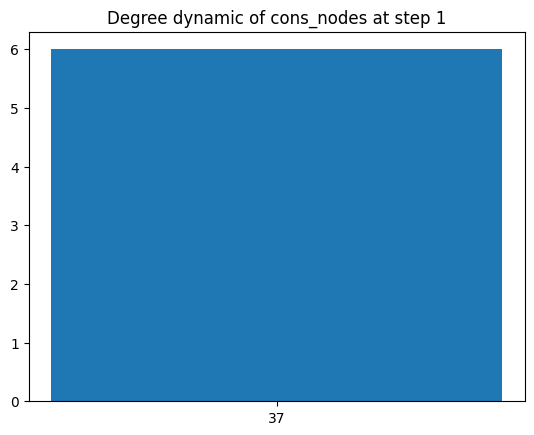

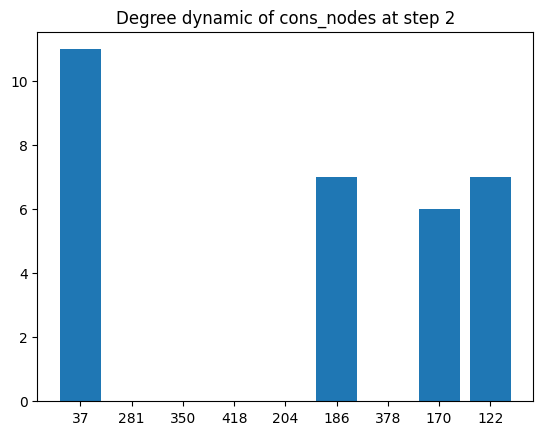

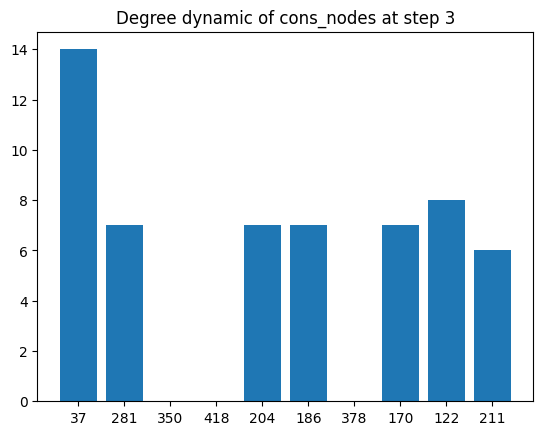

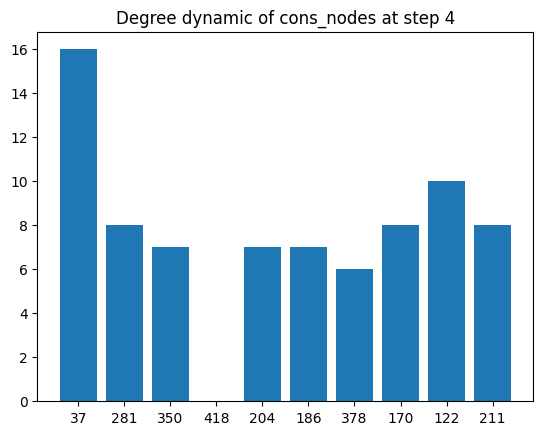

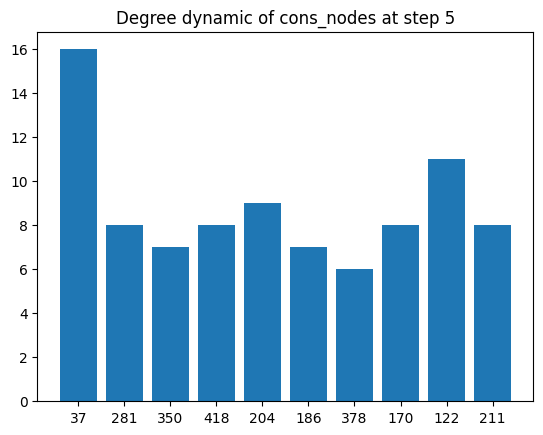

In [103]:
n,m = 500,6

cons_nodes = np.random.choice(np.arange(n),10)
degree_dynamics = generate_degree_dynamics(n,m,cons_nodes)

for i in range(len(degree_dynamics)):

  plt.bar(np.array(cons_nodes).astype(str), degree_dynamics[i])
  plt.title(f'Degree dynamic of cons_nodes at step {i + 1}')
  plt.show()